# Reverse Training
----

<h4> Description </h4>
What if I swap the training sample for the SDSS+GALEX+WISE? Does the ML estimator also works when applied to Cosmos Deep Field? How much a shallow local universe sample can be extrapolated to the high universe? 


In this notebook I hope to answer this questions. 

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Cosmos Sample

In [2]:
path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
fname = path+'desCosmosML_sample.fits'
joined = Table(getdata(fname))

In [3]:
### get machine learning selection

In [4]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew

In [5]:
path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

y_train_err = np.array(joined['smass_err'][joined['Train']])

In [6]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [97]:
x_train_small = x_train1d[:,:]
x_test_small = x_test1d[:,:]

## Training Sample

In [8]:
import sys

sys.path.append('/data/des81.a/data/jesteves/GitHub/galpro')
from galpro import model
from galpro.convert_mag_to_lupmag import get_input_galpro

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']

x_target = get_input_galpro(mags[mask],ztrue[mask])

from astropy.cosmology import WMAP9 as cosmo

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,2]]

y_target = np.array(data['sdss_mass'][mask])
x_target_small = x_target1d[:,:]

## Training with ML Architectures

In [70]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import time

# from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
n_cores = 41

ann_pipeline = make_pipeline(MLPRegressor())
rf_pipeline = make_pipeline(RandomForestRegressor(n_jobs=n_cores))
gradient_pipeline = make_pipeline(GradientBoostingRegressor())
# svm_pipeline = make_pipeline(BaggingRegressor(SVR(), max_samples=1.0 / n_estimators,
#                              n_estimators=n_estimators,n_jobs=n_cores))

svm_pipeline = make_pipeline(SVR())

estimators = [('ANN', ann_pipeline),
              ('Random Forest', rf_pipeline),
              ('Gradient Boosting', gradient_pipeline),
              ('SVM', svm_pipeline)]

In [71]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_target))
x = x_target_small[idx,:]
y = y_target[idx]

In [72]:
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)
    print('Elapsed time: %.2f sec'%self.elapsed_time)
    
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.80 sec

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.55 sec

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 3.01 sec

-------------------------
Machine Learning Training: SVM
Elapsed time: 5.85 sec



In [73]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=3)
    ax.scatter(y_true, y_pred, alpha=0.9,s=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=16)
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
    
def median_abs_deviation(x,scale=1.0):
    return np.median(np.abs(x-np.median(x)))/scale

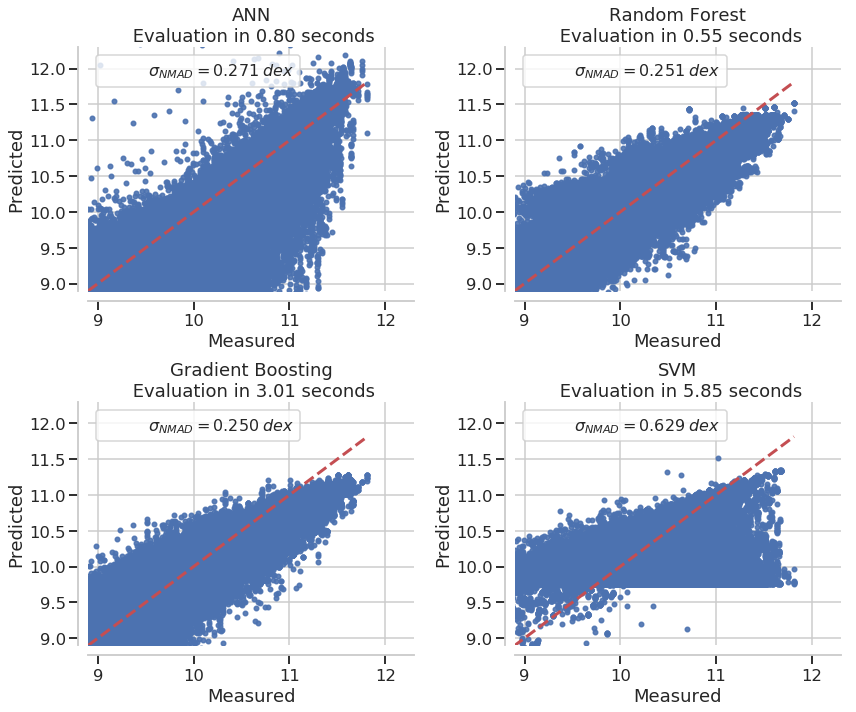

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_train_pred = est.predict(x_train_small)
    snmad = median_abs_deviation((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0],scale=1/1.4826)
    offset = np.median((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0])
    plot_regression_results(
        ax, y_train1d, y_train_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,12.3)
    ax.set_ylim(8.9,12.3)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors_trainSDSS_applyCosmos.png',dpi=100,facecolor='w',transparent=False)

In [99]:
def plot_residual_z(ax, y_true,y_pred,z, title, scores, elapsed_time, xlabel='redshift'):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([z.min(), z.max()],
            [0., 0.],
            '--r', linewidth=3)
    
    res = y_pred-y_true
    ax.scatter(z, res, alpha=0.1, s=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([y_true.min(), y_true.max()])
#     ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Residual')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=16)
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


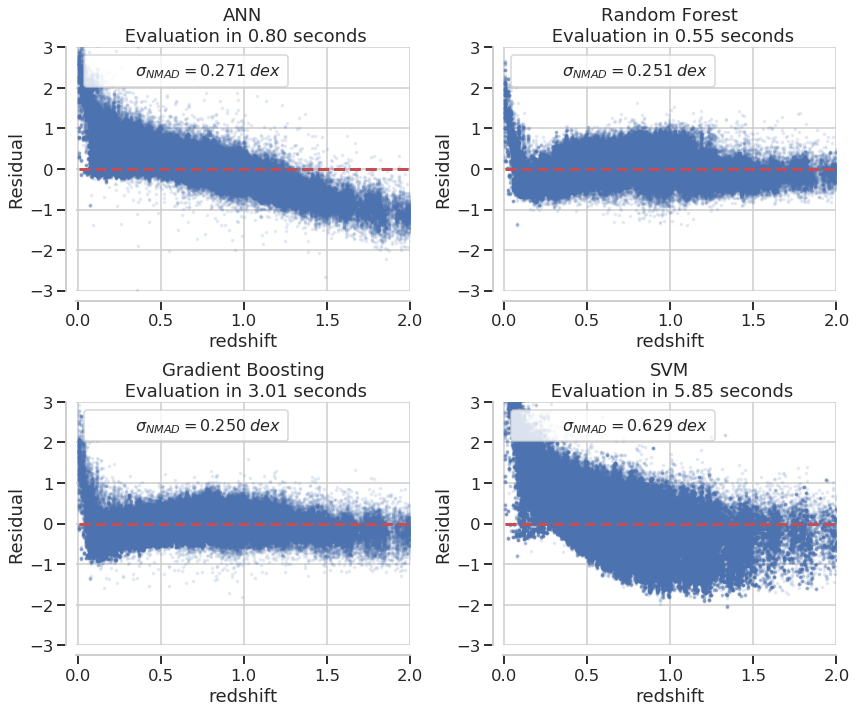

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_train_pred = est.predict(x_train_small)
    snmad = median_abs_deviation((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0],scale=1/1.4826)
    offset = np.median((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0])
    plot_residual_z(ax, y_train1d, y_train_pred+offset, x_train_small[:,-2],
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(-0.01,2.0)
    ax.set_ylim(-3.,3.)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# fig.savefig('compare_different_ml_predictors_trainSDSS_applyCosmos.png',dpi=100,facecolor='w',transparent=False)

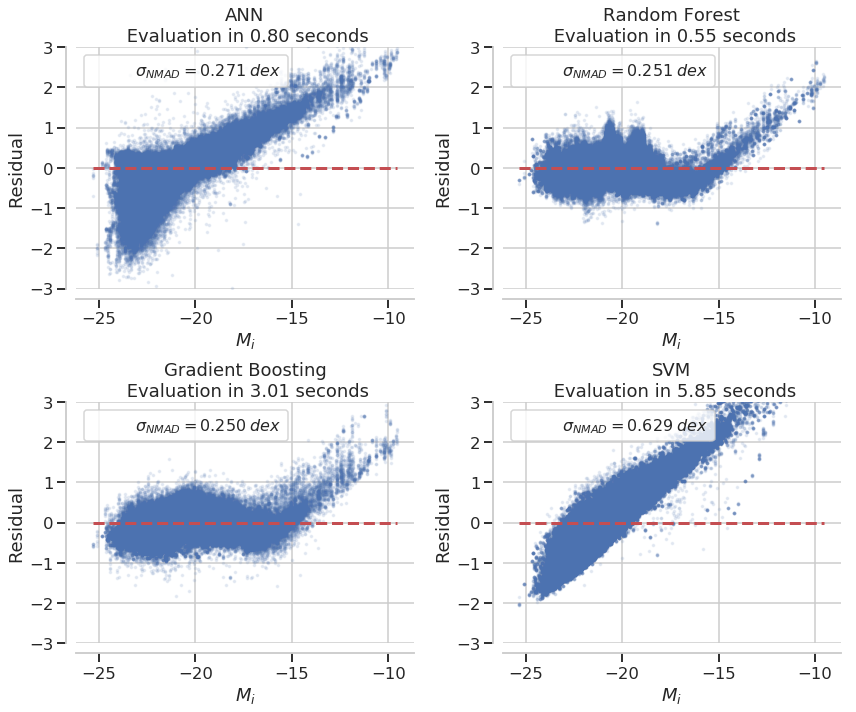

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_train_pred = est.predict(x_train_small)
    snmad = median_abs_deviation((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0],scale=1/1.4826)
    offset = np.median((y_train1d-y_train_pred)[x_train_small[:,-1]<=-19.0])
    plot_residual_z(ax, y_train1d, y_train_pred+offset, x_train_small[:,-1],
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time,xlabel=r'$M_{i}$')
    #ax.set_xlim(-0.01,2.0)
    ax.set_ylim(-3.,3.)
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# fig.savefig('compare_different_ml_predictors_trainSDSS_applyCosmos.png',dpi=100,facecolor='w',transparent=False)

The SDSS local volume sample was not abble to predict less luminous objects. The main trends are not evolutionary are luminous depedent instead. However, if the prediction is restricted to the trained luminosity range the decision tree based codes perfoms well. 

Altough the precision is worse, ~0.25 dex, we should keep in mind that the training set is 10 times smaller than COSMOS.

## Feature Importance

In [78]:
import time
import numpy as np

est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.150 seconds


In [79]:
feature_names = ['Mag_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names+= [r'$M_i$']
feature_names

['Mag_g',
 'Mag_r',
 'Mag_i',
 'Mag_z',
 '$(g - r)$',
 '$(r - i)$',
 '$(i - z)$',
 'Mag_err_g',
 'Mag_err_r',
 'Mag_err_i',
 'Mag_err_z',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift',
 '$M_i$']

In [80]:
len(feature_names)

16

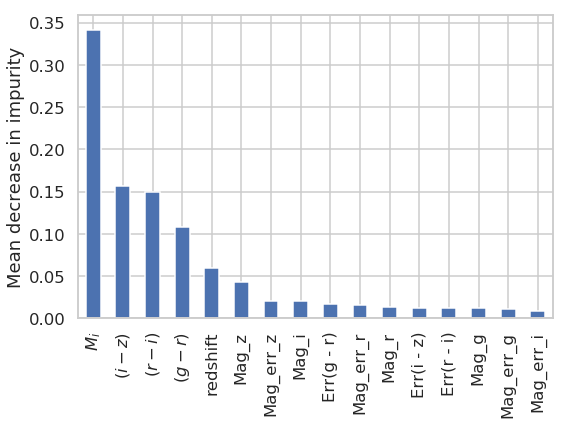

In [81]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

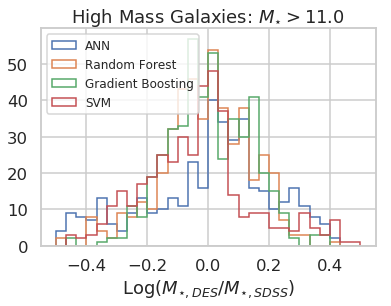

In [82]:
# xhigh = y_target>11.6
for name, est in estimators:
    ypred = est.predict(x_test_small)
    res = ypred-y_test1d
    yhigh = y_test1d>11.0
    #yhigh = (ypred-np.median(res))>11.0
    plt.hist((res-np.median(res[yhigh]))[yhigh], bins=np.linspace(-0.5,0.5,31),histtype='step',label=name)
    plt.title('High Mass Galaxies: $M_{\star}>11.0$')
plt.xlabel('Log($M_{\star,DES}/M_{\star,SDSS}$)')
plt.legend(fontsize=12,loc=2)